In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score, precision_score, accuracy_score, classification_report
os.chdir('..')

%pwd


'c:\\Users\\larakim\\Documents\\Data_train\\Satellite_image_classif\\ML-pipeline-Satellite-image-classification'

In [2]:
import keras
import tensorflow as tf

directory = 'artifacts/data_ingestion/data/'
# classes = ['green_area', 'water', 'desert', 'cloudy']

# Initialize the ImageDataGenerator (here, we're just rescaling the images)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
    validation_split=0.2) 

ds_train = train_datagen.flow_from_directory(
    directory,
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    seed=10,
    subset='training',
    interpolation="nearest",
    target_size=(150, 150),
)
ds_val = train_datagen.flow_from_directory(
    directory,
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    seed=10,
    subset='validation',
    interpolation="nearest",
    target_size=(150, 150),
)
labels = dict((v,k) for k,v in (ds_val.class_indices).items())

print ("In train_generator ")
for i in range(len (ds_train.class_indices)):
    print(labels[i],":\t",list(ds_train.classes).count(i))
print ("") 

print ("In validation_generator ")
for i in range(len (ds_val.class_indices)):
    print(labels[i],":\t",list(ds_val.classes).count(i))
print ("") 

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.
In train_generator 
cloudy :	 1200
desert :	 905
green_area :	 1200
water :	 1200

In validation_generator 
cloudy :	 300
desert :	 226
green_area :	 300
water :	 300



In [3]:
# Fetch a batch of images and labels
images, labels = next(ds_train)

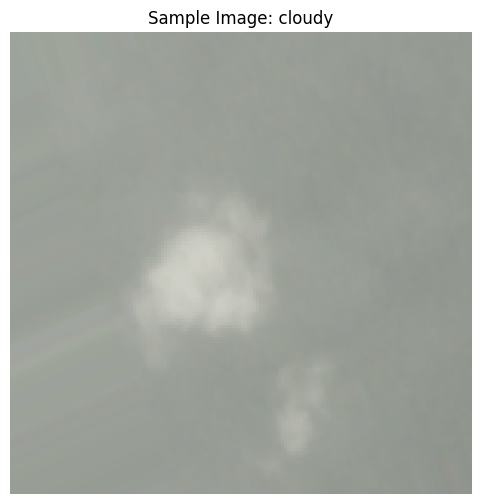

In [4]:
# Convert the one-hot encoded labels to the class index (integer)
class_indices = np.argmax(labels, axis=1)

# Get the class labels (names) from the generator
class_labels = list(ds_train.class_indices.keys())

# Plot the first image in the batch
plt.figure(figsize=(6, 6))
plt.imshow(images[0].astype(int))
plt.title(f"Sample Image: {class_labels[class_indices[0]]}")
plt.axis('off')  # Hide the axis
plt.show()

In [12]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x,training=False)  
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
predictions = keras.layers.Dense(4,activation='softmax')(x)

# Create the model
model = keras.Model(inputs,predictions)

# Print the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                           

In [13]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [14]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

# EarlyStopping to stop training when the validation loss has not improved after 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# ReduceLROnPlateau to reduce the learning rate when the validation loss has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', min_lr=0.00001)


In [15]:
ds_train.reset()
ds_val.reset()

# Fit the model
history = model.fit(
    ds_train,
    epochs=2,  # Adjust based on your needs
    validation_data=ds_val,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/2
141/141 [==============================] - ETA: 0s - loss: 1.1133 - accuracy: 0.5572
Epoch 1: val_loss improved from inf to 0.88415, saving model to best_model.h5


c:\Users\larakim\miniconda3\envs\image_classif\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


141/141 [==============================] - 154s 1s/step - loss: 1.1133 - accuracy: 0.5572 - val_loss: 0.8841 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 2/2
141/141 [==============================] - ETA: 0s - loss: 0.8180 - accuracy: 0.7971
Epoch 2: val_loss improved from 0.88415 to 0.80853, saving model to best_model.h5
141/141 [==============================] - 154s 1s/step - loss: 0.8180 - accuracy: 0.7971 - val_loss: 0.8085 - val_accuracy: 0.7993 - lr: 0.0010


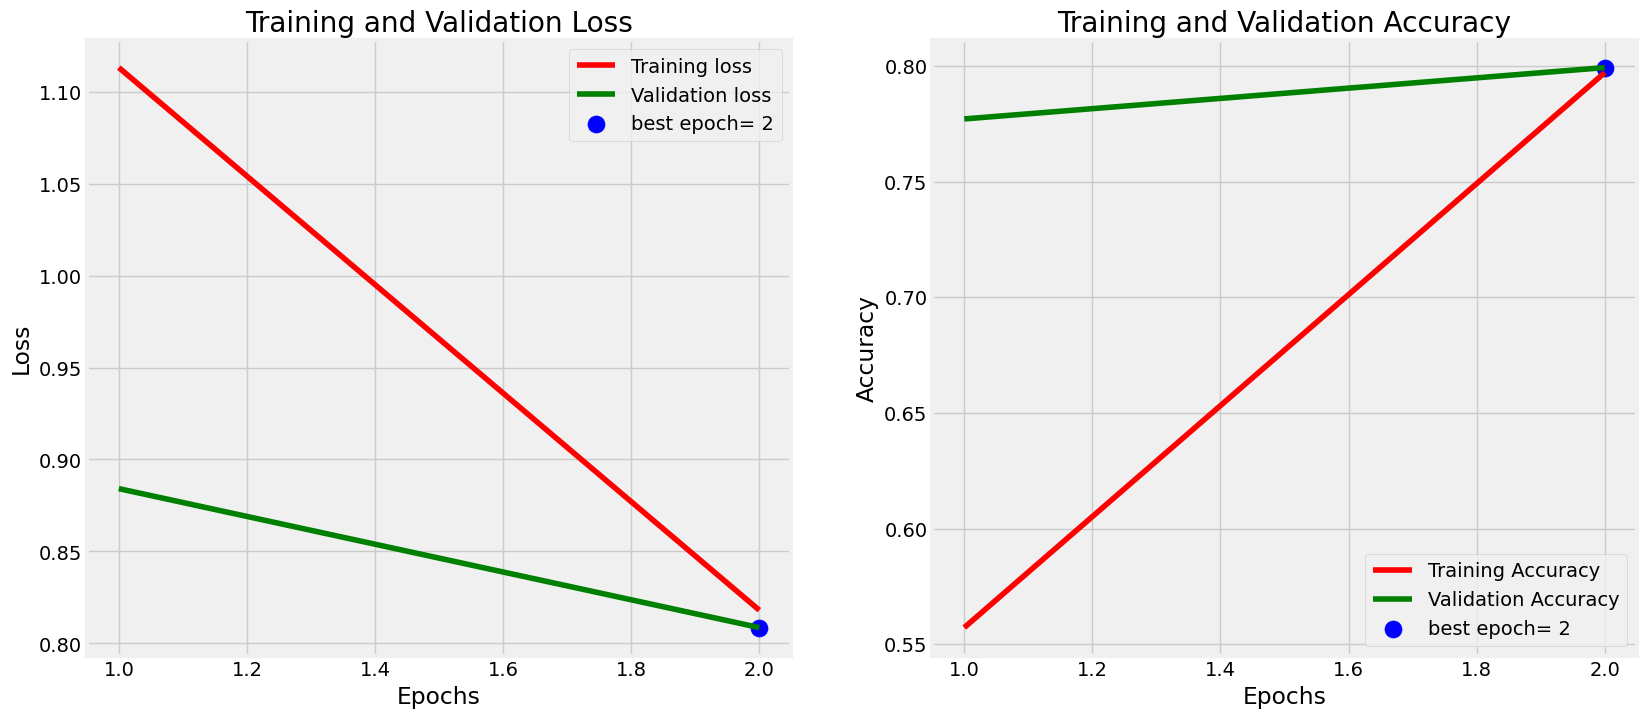

In [16]:
# set an accuracy measurement metrics for the code
# save the history of the measurement metrices after each iteration (epoch)
# return the lowest loss value and the greatest accuracy value after the completion of 
# the epochs

tr_acc= history.history['accuracy']
tr_loss= history.history['loss']
val_acc= history.history['val_accuracy']
val_loss= history.history['val_loss']
index_loss= np.argmin(val_loss)
val_lowest= val_loss[index_loss]
index_acc= np.argmax(val_acc)
acc_highest= val_acc[index_acc]
Epochs= [i+1 for i in range(len(tr_acc))]
loss_label= f'best epoch= {str(index_loss+ 1)}'
acc_label= f'best epoch= {str(index_acc+ 1)}'

# Plot training metrics and log history of training 

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

# plot two graphs in one space for ease of comparison

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss+ 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot the training and testing accuracy metrices

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc+ 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [56]:
labels = (ds_val.class_indices)
labels

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

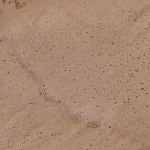

In [5]:
image_path = 'artifacts/data_ingestion/data/desert/desert(8).jpg'
image = keras.utils.load_img(image_path,interpolation="nearest",
    target_size=(150, 150))
input_arr = keras.utils.img_to_array(image)
image

In [10]:
labels = dict((v,k) for k,v in (ds_val.class_indices).items())
labels

{0: 'cloudy', 1: 'desert', 2: 'green_area', 3: 'water'}

In [17]:
# model2.save('dfsdf.keras')

In [9]:
tp = (150, 150, 3)
tuple(list([1]) + list(tp))

(1, 150, 150, 3)

In [6]:
model2 = tf.keras.models.load_model('best_model.h5')
predicted_class = labels[np.argmax(model2.predict(input_arr.reshape(1,150, 150, 3)))]
predicted_class


1/1 [==============================] - 1s 981ms/step


array([1., 0., 0., 0.], dtype=float32)

In [8]:
model2.predict_on_batch(input_arr.reshape(1,150, 150, 3))

array([[0.22823271, 0.58042014, 0.04452696, 0.14682017]], dtype=float32)

In [13]:
from img_classif.utils.common import read_yaml
from pathlib import Path
import yaml 
params_fn = Path("params.yaml")
params = read_yaml(params_fn)

params = dict(params)
params['epochs'] = 5
with open("params2.yaml", 'w') as outfile:
    yaml.dump(params, outfile)

['2024-04-11 10:43:49,281':'INFO':'common':'params.yaml loaded successfully']


In [56]:
predictions = model.predict(ds_val, verbose = 1)

36/36 [==============================] - 35s 957ms/step


In [57]:
predicted_class_indices=np.argmax(predictions,axis=1)
predictedLables= [labels[k] for k in predicted_class_indices]
actualLables= [labels[k] for k in ds_val.classes]


accuracy_score(actualLables, predictedLables)

0.7557726465364121

In [58]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

      cloudy       0.99      0.48      0.64       300
      desert       0.86      0.79      0.82       226
  green_area       0.79      0.91      0.85       300
       water       0.60      0.86      0.71       300

    accuracy                           0.76      1126
   macro avg       0.81      0.76      0.75      1126
weighted avg       0.81      0.76      0.75      1126



In [80]:
cr = classification_report(actualLables, predictedLables, output_dict=True)
di = cr['weighted avg']
di['accuracy'] = cr['accuracy']
di

{'precision': 0.806998501732054,
 'recall': 0.7557726465364121,
 'f1-score': 0.7496775062715,
 'support': 1126.0,
 'accuracy': 0.7557726465364121}

In [68]:
list(ds_val.classes)
predicted_class_indices=np.argmax(predictions,axis=1)
predicted_class_indices



array([0, 2, 3, ..., 3, 3, 2], dtype=int64)

In [73]:
# Calculate precision
precision_metric = tf.keras.metrics.Precision()
precision_metric.update_state(list(ds_val.classes), predicted_class_indices)
precision_metric.result().numpy()

0.8401222

In [80]:
img,c = ds_val.next()

In [84]:
model.predict(ds_val)

 2/36 [>.............................] - ETA: 1:29

KeyboardInterrupt: 

In [ ]:
class_labels = list(ds_train.class_indices.keys())

In [ ]:
import keras

directory = 'artifacts/data_ingestion/data'

ds = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",  #categorical
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=10,
    validation_split=0.3,
    subset='training',
    interpolation="bilinear",
)

In [278]:
ds2 = ds.unbatch()

AttributeError: 'DirectoryIterator' object has no attribute 'unbatch'

In [264]:
images = list(ds2.map(lambda x,y:x))
labels = list(ds2.map(lambda x,y:y))

In [265]:
len(list(images))

5068

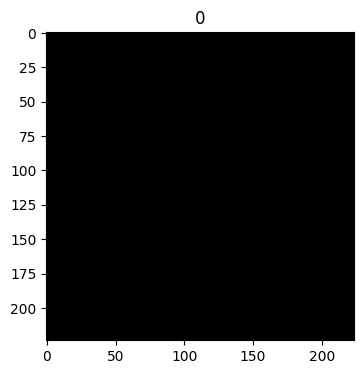

In [270]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

i= 55

imgg = images[i]

plt.figure(figsize=(4,4))
plt.imshow(tf.cast(imgg, tf.int64))
plt.title(labels[i].numpy())
plt.show()

In [267]:
images[i]

<tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>

In [159]:
set([labels[k].numpy() for k in range(len(labels))])

{0, 1, 2, 3}

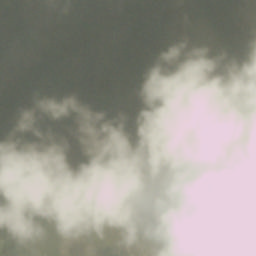

In [260]:
keras.utils.load_img(
    'artifacts/data_ingestion/data/cloudy/train_12.jpg',
    color_mode="rgb",
    target_size=None,
    interpolation="nearest",
    keep_aspect_ratio=False,
)

Found 5631 files belonging to 4 classes.


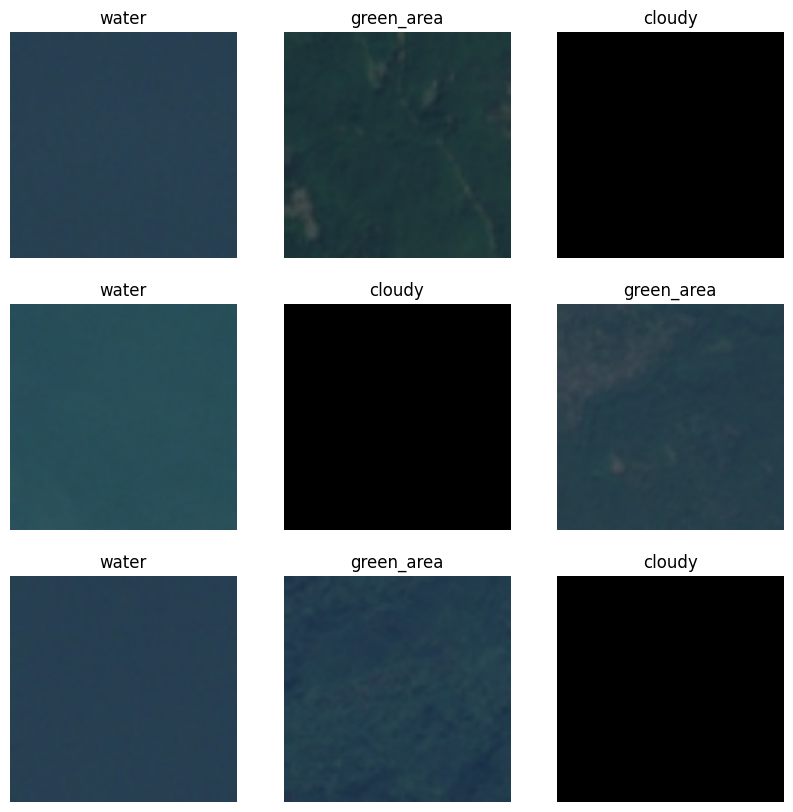

In [261]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('artifacts/data_ingestion/data',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))


class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [4]:
x = (150,150,3)
x[0:2]

(150, 150)